# POSE MODEL CAPSTONE PROJECT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os,glob,shutil

In [ ]:
os.chdir('drive/My Drive/Colab Notebooks')

In [ ]:
!unzip 'capstone.zip'
!unzip Action_Dataset.zip
!unzip Pose_Dataset.zip
!unzip Pose_Model.zip

Archive:  capstone.zip
replace Action_Dataset.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Action_Dataset.zip      
  inflating: Pose_Dataset.zip        
  inflating: Pose_Model.zip          
Archive:  Action_Dataset.zip
replace Action_Dataset/action_joints.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  Pose_Dataset.zip
replace Pose_Dataset/test/test0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  Pose_Model.zip
replace pose_model_50.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# **PART 1. CNN Based Pose estimation** **bold text**

---



In [ ]:
# Import required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
%tensorflow_version 1.x
import tensorflow as tf
from keras.models import Sequential,Model,save_model,load_model
from keras.layers import Dense,Conv2D, Dropout,MaxPooling2D,Flatten,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.model_selection import train_test_split
import random

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
#Read the joint coordinates to train and test dataframes
train_lab=pd.read_csv('Pose_Dataset/train_joints_coords.csv',header=None)
test_lab=pd.read_csv('Pose_Dataset/test_joints_coords.csv',header=None)
                       

In [ ]:
#column 0 contains the file name. Make this as the index in the 2 dataframes
train_lab.set_index([0],inplace=True)
test_lab.set_index([0],inplace=True)
print("Train Labels \n",train_lab.head(2))

Train Labels 
              1    2    3    4    5   6    7   8   9   10  11   12  13   14
0                                                                         
train0.jpg  190  160  149  137  151  84  122  34  47  77  31  141  31  190
train1.jpg  192  137  148  122  138  77  109  40  47  79  36  140  34  184


In [ ]:
# Read the image file as per file name in train_lab[0],test_lab[0] (so that sequence is mainained) using cv2.imread
# Store the image read into a numpy array.

#initialise np array to hold the training image data
x_train=np.zeros((len(train_lab),224,224,3))
count1=0
for file in train_lab.index:
  x_train[count1]=cv2.imread('Pose_Dataset/train/'+file,1)
  count1+=1

In [ ]:
##initialise np array to hold the test image data-------------------------------------------------------------------------------------
x_test=np.zeros((len(test_lab),224,224,3))
count2=0
for file in test_lab.index:
  x_test[count2]=cv2.imread('Pose_Dataset/test/'+file,1)
  count2+=1



In [ ]:
#SAVE the np.array for the images to reload later, as it consumes a lot of time
np.save("x_train",x_train)
np.save("x_test",x_test)


#x_train=np.load("x_train.npy")
#x_test=np.load("x_test.npy")

In [ ]:
#Convert the labels (Joint coordinates) into np array called y_train and y_test
y_train=np.array(train_lab)
print(y_train.shape)

y_test=np.array(test_lab)
print(y_test.shape)


(4429, 14)
(574, 14)


In [ ]:
#scale the input image data
x_train/=255.0
x_test/=255.0

## 1.1 Define CNN model
#Define a CNN model so that input images are taken and the model predicts 14 joint coordinates.
#This is a Regression problem (not classification), so we need to use mean_squared_error for loss.

In [ ]:
pose_model=Sequential([
                       Conv2D(64,kernel_size=3,padding='same',input_shape=(224,224,3),activation='relu'),
                       MaxPooling2D(padding='same'),
                       Conv2D(128,kernel_size=3,padding='same',activation='relu'),
                       Dropout(0.2),
                       MaxPooling2D(padding='same'),
                       Conv2D(128,kernel_size=3,padding='same',activation='relu'),
                       Dropout(0.2),
                       MaxPooling2D(padding='same'),
                       Flatten(),
                       Dense(14,activation='relu')

])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
pose_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 128)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 128)      

In [ ]:
##model compile. Using MSE as loss, as its a regression problem.
pose_model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse'])

In [ ]:
#1st run with higher batch_size of 200 so that convergence is faster
#pose_model.fit(x_train,y_train,batch_size=200,epochs=10,validation_data=(x_test,y_test))

#2nd run with smaller batch_size 50 
pose_model.fit(x_train,y_train,batch_size=50,epochs=10,validation_data=(x_test,y_test))

Train on 4429 samples, validate on 574 samples
Epoch 1/10
4429/4429 [==============================] - 23s 5ms/step - loss: 2627.3000 - mse: 2627.2998 - val_loss: 3987.8127 - val_mse: 3987.8127
Epoch 2/10
4429/4429 [==============================] - 21s 5ms/step - loss: 2603.7806 - mse: 2603.7805 - val_loss: 4181.6521 - val_mse: 4181.6523
Epoch 3/10
4429/4429 [==============================] - 21s 5ms/step - loss: 2588.4222 - mse: 2588.4219 - val_loss: 4158.9357 - val_mse: 4158.9355
Epoch 4/10
4429/4429 [==============================] - 21s 5ms/step - loss: 2111.0437 - mse: 2111.0435 - val_loss: 2524.9493 - val_mse: 2524.9492
Epoch 5/10
4429/4429 [==============================] - 21s 5ms/step - loss: 812.4472 - mse: 812.4471 - val_loss: 2846.8947 - val_mse: 2846.8945
Epoch 6/10
4429/4429 [==============================] - 21s 5ms/step - loss: 777.8765 - mse: 777.8763 - val_loss: 2565.2326 - val_mse: 2565.2327
Epoch 7/10
4429/4429 [==============================] - 21s 5ms/step - loss

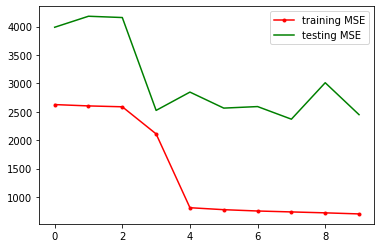

In [ ]:
#save the model
pose_model.save("pose_model")

#pose_model performance
trn_mse=pose_model.history.history['mse']
tst_mse=pose_model.history.history['val_mse']
plt.plot(trn_mse,'r.-',label='training MSE')
plt.plot(tst_mse,'g-',label='testing MSE')
plt.legend()

##1.2 The above model's accuracy is not improving for test data. The model seems to be UNDERFITTING and a more complex model is required.

Improvements:
- add more number of dense and CNN layers
*-smaller learning_rate


In [ ]:
pose_model2=Sequential([
                       Conv2D(64,kernel_size=5,padding='same',input_shape=(224,224,3),activation='relu'),
                       MaxPooling2D(padding='same'),
                       Conv2D(128,kernel_size=3,padding='same',activation='relu'),
                       MaxPooling2D(padding='same'),
                       Dropout(0.2),
                       Conv2D(256,kernel_size=3,padding='same',activation='relu'),
                       MaxPooling2D(padding='same'),
                       Dropout(0.2),                    
                       Flatten(),
                       Dense(224,activation='relu'),
                       Dropout(0.2),
                       Dense(14,activation='relu')                      

])

In [ ]:
from keras.callbacks.callbacks import ReduceLROnPlateau
rl=ReduceLROnPlateau(patience=4)
from keras.optimizers import Adam
adam=Adam(learning_rate=0.0005)   ##used a lower learning rate than the standard 0.001

pose_model2.compile(loss='mean_squared_error',optimizer=adam,metrics=['mse','mae','mape'])

In [ ]:
#1st run with batch_size of 100 so that convergence is faster
#pose_model2.fit(x_train,y_train,batch_size=100,epochs=20,validation_data=(x_test,y_test),callbacks=[rl])

#2nd run with lower batch size
pose_model2.fit(x_train,y_train,batch_size=30,epochs=15,validation_data=(x_test,y_test),callbacks=[rl])

Train on 4429 samples, validate on 574 samples
Epoch 1/15
4429/4429 [==============================] - 26s 6ms/step - loss: 505.4050 - mse: 505.4050 - mae: 15.9443 - mape: 18.0797 - val_loss: 969.7671 - val_mse: 969.7672 - val_mae: 24.0727 - val_mape: 22.6428
Epoch 2/15
4429/4429 [==============================] - 25s 6ms/step - loss: 492.1525 - mse: 492.1525 - mae: 15.7661 - mape: 17.7095 - val_loss: 624.1356 - val_mse: 624.1357 - val_mae: 17.8694 - val_mape: 18.2010
Epoch 3/15
4429/4429 [==============================] - 25s 6ms/step - loss: 443.2480 - mse: 443.2480 - mae: 15.0151 - mape: 16.8436 - val_loss: 768.2490 - val_mse: 768.2490 - val_mae: 20.9620 - val_mape: 20.0324
Epoch 4/15
4429/4429 [==============================] - 25s 6ms/step - loss: 415.1564 - mse: 415.1565 - mae: 14.5101 - mape: 16.1881 - val_loss: 671.8494 - val_mse: 671.8493 - val_mae: 19.8834 - val_mape: 18.9517
Epoch 5/15
4429/4429 [==============================] - 25s 6ms/step - loss: 385.9019 - mse: 385.9020

In [ ]:
#pose_model2 performance - define function
def modelstat(mod):
  plt.subplot(1,2,1)
  trn_mape=mod.history.history['mape']
  tst_mape=mod.history.history['val_mape']
  plt.plot(trn_mape,'r.-',label='training MAPE')
  plt.plot(tst_mape,'g-',label='testing MAPE')
  plt.legend()
  plt.subplot(1,2,2)
  trn_mse=mod.history.history['mse']
  tst_mse=mod.history.history['val_mse']
  plt.plot(trn_mse,'r.-',label='training MSE')
  plt.plot(tst_mse,'g-',label='testing MSE')
  plt.legend()

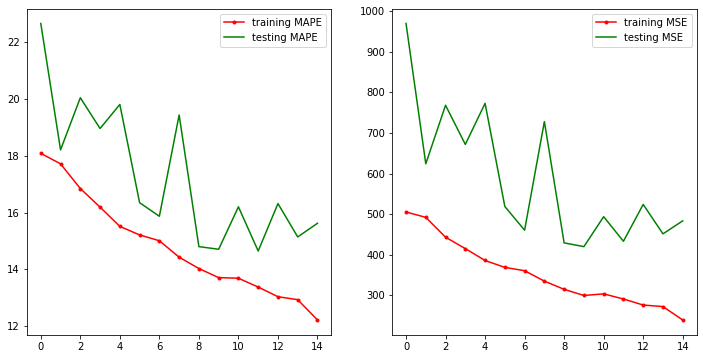

In [ ]:
#call the function
plt.figure(figsize=(12,6))
modelstat(pose_model2)

In [ ]:
#The pose_model2 MSE and MAOE is still reducing. So lets run for another 15 epochs
#3rd run 
pose_model2.fit(x_train,y_train,batch_size=20,epochs=15,validation_data=(x_test,y_test),callbacks=[rl])

Train on 4429 samples, validate on 574 samples
Epoch 1/15
4429/4429 [==============================] - 31s 7ms/step - loss: 228.8965 - mse: 228.8965 - mae: 11.0655 - mape: 12.0137 - val_loss: 496.6050 - val_mse: 496.6050 - val_mae: 16.0701 - val_mape: 15.9615
Epoch 2/15
4429/4429 [==============================] - 28s 6ms/step - loss: 230.2336 - mse: 230.2336 - mae: 11.1114 - mape: 12.0146 - val_loss: 474.4788 - val_mse: 474.4788 - val_mae: 15.4083 - val_mape: 15.4552
Epoch 3/15
4429/4429 [==============================] - 28s 6ms/step - loss: 221.5668 - mse: 221.5668 - mae: 10.8750 - mape: 11.7883 - val_loss: 508.7967 - val_mse: 508.7967 - val_mae: 16.2515 - val_mape: 16.0497
Epoch 4/15
4429/4429 [==============================] - 28s 6ms/step - loss: 221.1306 - mse: 221.1306 - mae: 10.9039 - mape: 11.7469 - val_loss: 494.5730 - val_mse: 494.5730 - val_mae: 15.7528 - val_mape: 15.6266
Epoch 5/15
4429/4429 [==============================] - 28s 6ms/step - loss: 222.6011 - mse: 222.6012

##1.3 The above model is better than the 1st model which underfit heavily. 
#Lets do transfer learning using VGG16 model

In [ ]:
from keras.applications.vgg16 import VGG16
vgg=VGG16()

553467904/553467096 [==============================] - 34s 0us/step


In [ ]:
#Define my own vgg16 empty model mypose to copy all layers of vgg16 (except the last two) and switching off learning.
# We will add our own layers at the end and make it trainable

mypose=Sequential([])


In [ ]:
#copy all vgg layers except last
for lyr in vgg.layers[:-1]:
  mypose.add(lyr)

#make all layers non trainable
for l in mypose.layers[:-1]:
  l.trainable=False

In [ ]:
#add Dense layer and retain as trainable
mypose.add(Dense(1000,activation='relu'))
mypose.add(Dense(100,activation='relu'))
mypose.add(Dense(14,activation='relu'))
mypose.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
mypose.compile(loss='mean_squared_error',optimizer=adam,metrics=['mse','mape'])
mypose.fit(x_train,y_train,batch_size=100,epochs=10,validation_data=(x_test,y_test),callbacks=[rl])

Train on 4429 samples, validate on 574 samples
Epoch 1/10
4429/4429 [==============================] - 17s 4ms/step - loss: 1989.3729 - mse: 1989.3730 - mape: 40.5158 - val_loss: 2567.7159 - val_mse: 2567.7161 - val_mape: 43.7017
Epoch 2/10
4429/4429 [==============================] - 15s 3ms/step - loss: 1969.0633 - mse: 1969.0632 - mape: 40.0921 - val_loss: 2518.8811 - val_mse: 2518.8811 - val_mape: 43.0489
Epoch 3/10
4429/4429 [==============================] - 15s 3ms/step - loss: 1957.6447 - mse: 1957.6449 - mape: 39.9158 - val_loss: 2518.9336 - val_mse: 2518.9336 - val_mape: 43.1388
Epoch 4/10
4429/4429 [==============================] - 15s 3ms/step - loss: 1954.0569 - mse: 1954.0571 - mape: 39.8688 - val_loss: 2516.4161 - val_mse: 2516.4160 - val_mape: 42.8756
Epoch 5/10
4429/4429 [==============================] - 15s 3ms/step - loss: 1950.0933 - mse: 1950.0933 - mape: 39.8021 - val_loss: 2515.4462 - val_mse: 2515.4465 - val_mape: 42.7930
Epoch 6/10
4429/4429 [================

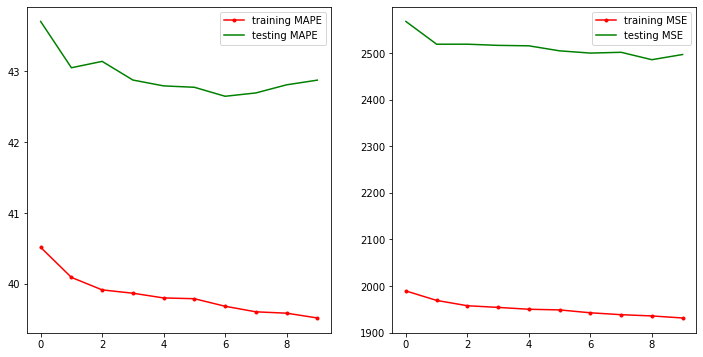

In [ ]:
plt.figure(figsize=(12,6))
modelstat(mypose)

##The transfer learning with vgg model performs worse than our own models.

##1.4 lets do transfer learning using the provided pretrained model "pose_model_50.h5"

In [ ]:

from keras.models import model_from_json
import json

with open('pose_model_50.json','r') as f:
    model_json= json.load(f)
model_json=json.dumps(model_json)

mypose_tf = model_from_json(model_json)
mypose_tf.load_weights('pose_model_50.h5')

In [ ]:
mypose_tf.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        9472      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          200768    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)             

In [ ]:
# Testing against Test set
from sklearn.metrics import mean_squared_error,mean_absolute_error

#get 100 random index number to sample  test set
#n=np.random.randint(0,len(y_test),100)

#Prediction with the model
ypred=mypose_tf.predict(x_test)

#Metrics
mse=mean_squared_error(y_test,ypred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(y_test,ypred)
print("MSE:{}, MAE:{}, RMSE:{} ".format(mse,mae,rmse))

MSE:985.7277833861642, MAE:19.40630102323738, RMSE:31.39630206546886 


## Comparing pretrained model **mypose_tf **with self created pose_model2

In [ ]:
# Testing against random 100 samples from Test set
ypred1=pose_model2.predict(x_test)

In [ ]:
mse1=mean_squared_error(y_test,ypred1)
rmse1=np.sqrt(mse1)
mae1=mean_absolute_error(y_test,ypred1)
print("MSE:{}, MAE:{}, RMSE:{} ".format(mse1,mae1,rmse1))

MSE:503.4313248007646, MAE:16.133337918355608, RMSE:22.43727534262493 


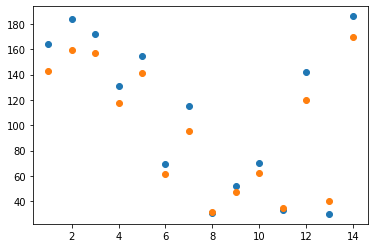

In [ ]:
# plotting the actual vs predicted joint coordimates for 1 sample case. 
#we will just compare the scalar value of each of the 14 joints predicted by the model
y_pred1=pose_model2.predict(np.expand_dims(x_test[50],axis=0))[0]
x=np.arange(1,15)
plt.scatter(x,y_test[50])
plt.scatter(x,y_pred1)

##*OVERALL*, pose_model2 has even better performance than the pretrained model over test data. So we will use this model.

#PART 2 - NN based Action Recognition model

---



---



*   Create a Dense network with pose joints as input, the last being a softmax layer to predict "hello" or "namaste"



In [ ]:
myaction_model=Sequential([
                           Dense(7,input_shape=(21,)),
                           LeakyReLU(),
                           Dropout(0.1),
                           #Dense(5,activation='relu'),
                           #Dropout(0.1),
                           Dense(2,activation='softmax')
                           
])

#model compile
myaction_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
myaction_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 7)                 154       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 16        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Read the action_joints.csv into DataFrame
action=pd.read_csv("Action_Dataset/action_joints.csv")
action.tail(2)

,url,j1x,j1y,j2x,j2y,j3x,j3y,j4x,j4y,j5x,j5y,j6x,j6y,j7x,j7y,label
20,hello_test.jpg,151,57,148,103,120,93,105,71,78,101,65,143,60,188,Hello
21,namaste_test.jpg,135,143,180,210,162,119,104,58,57,115,56,201,115,148,Namaste


In [ ]:
#Seperate the validation data into a different dataframe
actionval=action[(action.url =='hello_test.jpg')|(action.url=='namaste_test.jpg')]

#remove the index 20 and 21 from action dataframe as they are used for validation
action.drop([20,21],axis=0,inplace=True)

###Dataset contains Hello actions performed using right-hand only. 
Hence, the model cannot recognize a Hello human action performed with left-hand. This issue can be solved by augmenting the action dataset by duplicating the existing actions further flipping the
coordinates horizontally. 

In [ ]:
#function to reverse the X coordinates and add back to the dataframe
def reverseX(datafr):
  c=[]
  for j in range(len(datafr)):
    data=np.array(datafr.iloc[j,:])
    for i in range(1,15,2):
      data[i]=224-data[i]
    c.append(data)
  return c



In [ ]:
#get list of flipped X coordinates for all records of action dataframe
action_flip=reverseX(action)

#convert to dataframe
action_flip=pd.DataFrame(action_flip,columns=action.columns,index=range(20,40))

In [ ]:
#combine with original dataframe action
action=pd.concat([action,action_flip],axis=0)
action.tail(2)

,url,j1x,j1y,j2x,j2y,j3x,j3y,j4x,j4y,j5x,j5y,j6x,j6y,j7x,j7y,label
38,namaste9.jpg,118,149,69,200,90,121,132,71,181,124,190,200,135,157,Namaste
39,namaste10.jpg,110,103,50,149,50,96,114,54,159,99,179,158,133,110,Namaste


Action recognition neural network can be built by directly considering x and y coordinates as
feature and action label as target. Since human can appear in any scale in a real scenario,
considering raw coordinates as features is not a good idea. This can be solved by considering
the skeleton of human pose points as graph, extracting the distance between every joint and
further normalizing the distance features. These distance features can be considered for
training the action recognition model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm=MinMaxScaler()

#function to calculate Eucledian Distance between 2 coordinate pairs
def dist(a,b):
  d=np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
  return d

#function to take 14 data points and bunch them into 7 (x,y) coordinates
def makecoord(d):
  z=np.array(d).reshape(7,2)
  return z

#function to calculate distance between each of the 7 points and return distance
def distance(z):
  d=[]
  for i in range(7):
    for j in range(i+1,7):
      d.append(dist(z[i],z[j]))
  d=mm.fit_transform(np.array(d).reshape(-1,1)).ravel()
  return d




In [ ]:
#create  new features to record the distance between each of the joints. store in list X_distance_features
X_distance_features1=[]
for i in range(len(action)):
  k=makecoord(action.iloc[i,1:15])
  X_distance_features1.append(distance(k))
X_distance_features1=np.array(X_distance_features1)

In [ ]:
action['link']=action['url'].apply(lambda x: str("Action_Dataset/")+str(x))
action['numlabel']=action['label'].apply(lambda x:0 if x=='Hello' else 1)

#create encoding for "label".
from keras.utils import to_categorical
y_label=to_categorical(action['numlabel'])


In [ ]:
#Lets train the model with the 40 data points
myaction_model.fit(X_distance_features1,y_label,epochs=20,batch_size=3,validation_split=0.2)

Train on 32 samples, validate on 8 samples
Epoch 1/20
32/32 [==============================] - 0s 8ms/step - loss: 0.9833 - accuracy: 0.0312 - val_loss: 1.3309 - val_accuracy: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 0s 2ms/step - loss: 0.9564 - accuracy: 0.1250 - val_loss: 1.2200 - val_accuracy: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 0s 2ms/step - loss: 0.9016 - accuracy: 0.0938 - val_loss: 1.1088 - val_accuracy: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 0s 2ms/step - loss: 0.8457 - accuracy: 0.1875 - val_loss: 1.0253 - val_accuracy: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 0s 2ms/step - loss: 0.7994 - accuracy: 0.2812 - val_loss: 0.9527 - val_accuracy: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 0s 2ms/step - loss: 0.7635 - accuracy: 0.4062 - val_loss: 0.8962 - val_accuracy: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 0s 2ms/step - loss: 0.7194 - accuracy: 0.

In [ ]:
# Testing on the 2 validation images 
#1. hello_test.jpg
#2. namaste_test.jpg

#Function to do the prediction
def pred(img):
         #read coordinates from action df
         z=np.array(actionval[actionval.url==str(img)][actionval.columns[1:15]])
         #convert to 7 coordinates
         z=makecoord(z)
         #convert 7 coordinates to distance features (21 combinations)
         z=distance(z)
         #Make prediction by calling the 'myaction_model' and pass the new features to return prediction
         pred=myaction_model.predict_classes(z.reshape(1,-1))[0]
         
         #Convert predicted class to text and return
         if pred==0:
           return "Hello"
         else:
           return "Namaste"

In [ ]:
pred('namaste_test.jpg')

'Namaste'

In [ ]:
pred('hello_test.jpg')

'Hello'

#PART 3: ACTION RECOGNITION IN VIDEO

---



---



###combine the 2 models. Assume that frame will be preprocessed and scaled

In [ ]:
def act(x):
    if x==0:
        return "Hello"
    else:
        return "Namaste"


def actionpred(frame):
  #predict joints based on CNN model
  pred_joints=pose_model2.predict(frame)

  #convert the 14 joint coordinates into 21 distance features using functions defined before
  X_distance_features_01=[]
  for i in range(len(pred_joints)):
    k=makecoord(pred_joints[i])
    X_distance_features_01.append(distance(k))
  X_distance_features_01=np.array(X_distance_features_01)

  #pass the distance feature to the NN model to predict action
  action_pred=myaction_model.predict_classes(X_distance_features_01)

  #convert the predicted class to text based on function 'act'
  action_pred1=list(map(act,action_pred))
  return action_pred1
  
  #return action_pred

##Using cv2 library read the video provided. take every 30th frame (movie is 30fps)

In [ ]:
cap = cv2.VideoCapture('Action_Dataset/Waving.mp4')

In [ ]:
#lets capture every 10th frame
success, image=cap.read()
f=[]
while success:
    counter=cap.get(1)
    success,image=cap.read()
    if counter%10==0:
        f.append(image)
cap.release()
cv2.destroyAllWindows()

In [ ]:
num_images=len(f)
print("Number of images captured from the video: {}".format(num_images))

Number of images captured from the video: 13


In [ ]:
#shape of the images
f[0].shape

(226, 282, 3)

In [ ]:
#we need the images in 224,224,3 shape. Write the images to temp file and use cv2 to read it back in right shape
new_images=[]
for item in f:
  cv2.imwrite('temp.jpg',item)
  img=cv2.imread('temp.jpg')
  new_images.append(cv2.resize(img,(224,224)))

In [ ]:
#convert new_images to np array to pass to prediction model and scaling
new_images=np.array(new_images)
new_images=new_images/255.0

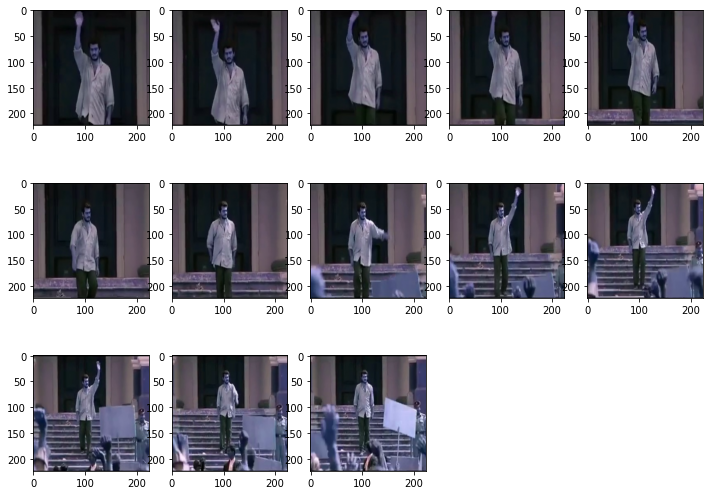

In [ ]:
plt.figure(figsize=(12,9))
for i in range(1,14):
  plt.subplot(3,5,i)
  plt.imshow(new_images[i-1])

##Moment of truth. Pass the sample images to the prediction model



In [ ]:
print(actionpred(new_images))

['Hello', 'Hello', 'Hello', 'Hello', 'Hello', 'Hello', 'Hello', 'Hello', 'Hello', 'Hello', 'Hello', 'Hello', 'Hello']


##We can see that the model predicts 'Hello' for each of the 13 frames captured from the video. Although the last 2 images are neither 'hello' nor 'namaste', we can see that the model classified it to the closest match 'hello'.

#**PROJECT SYNOPSIS**

---



---



--



```
`# This is formatted as code`
```


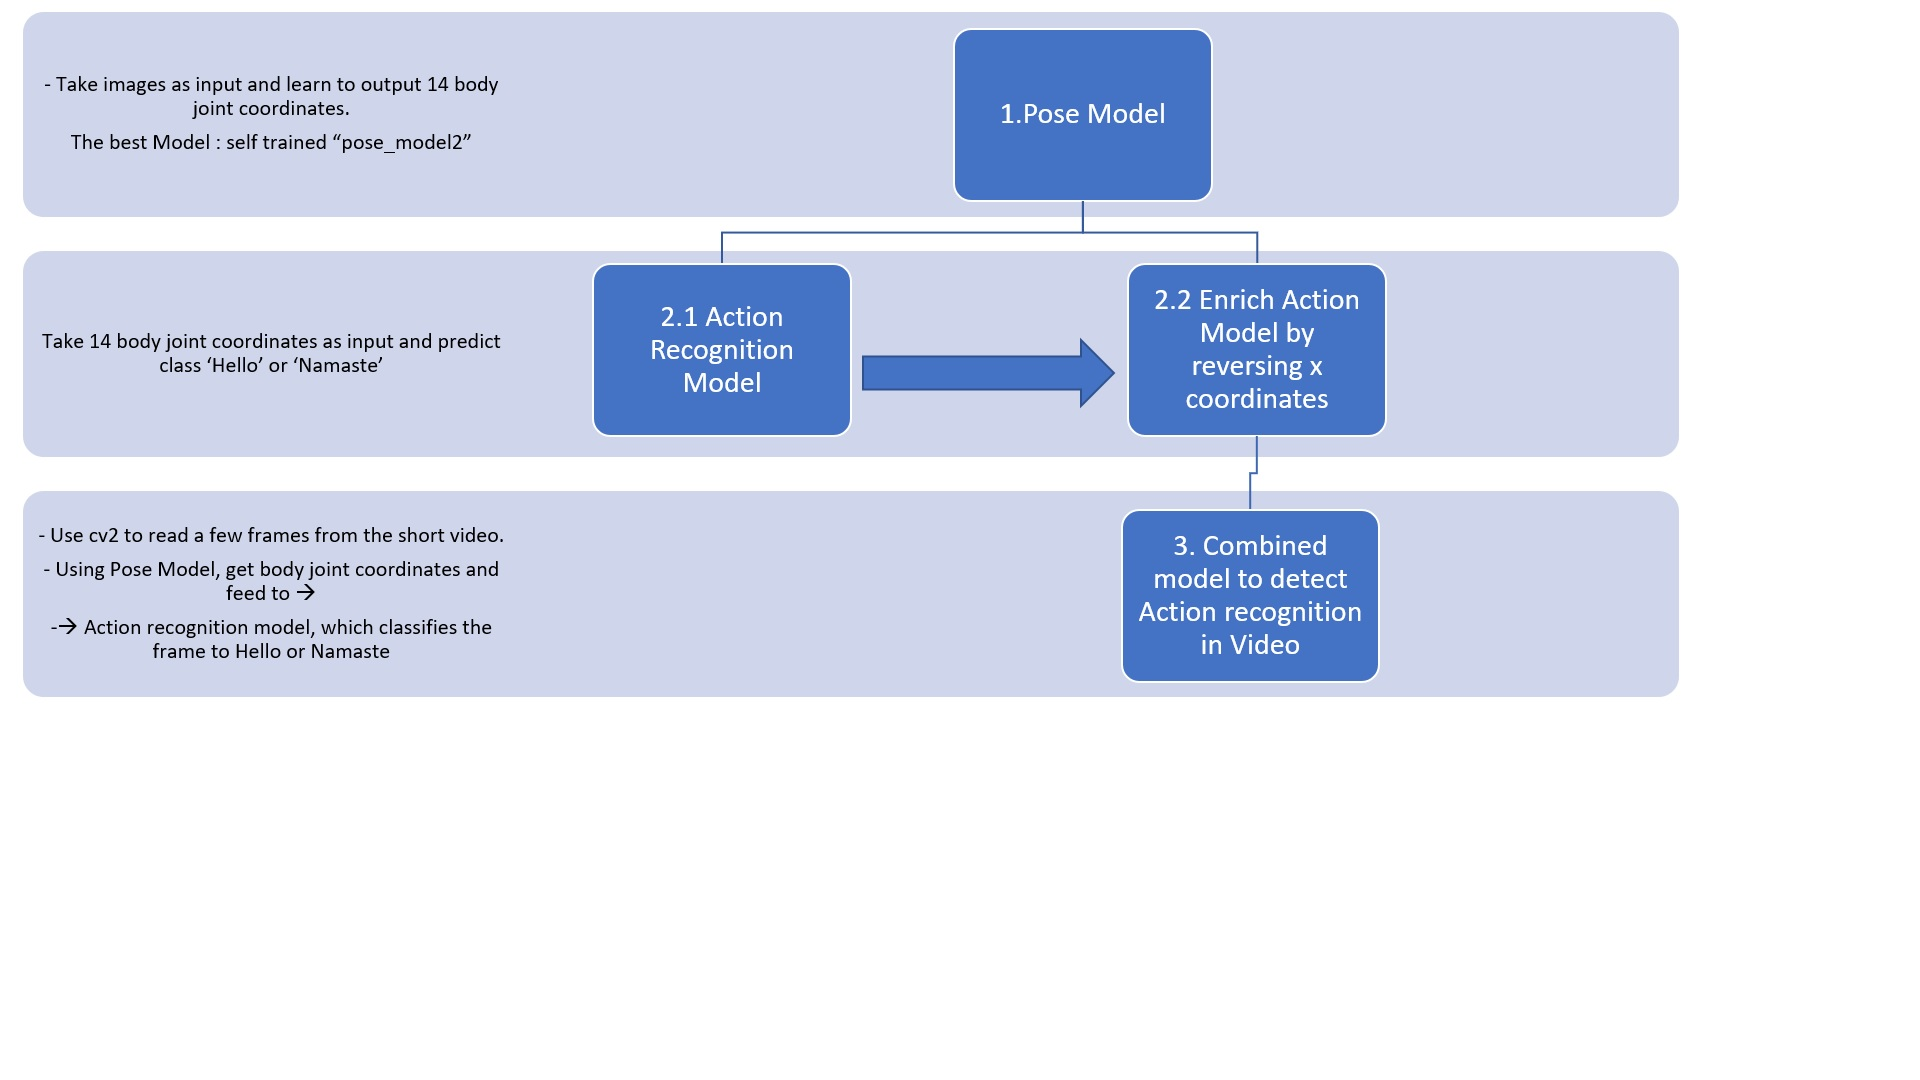

###1.POSE MODEL
1.1  As the intention was to output/preduct the 14 body joint coordinates, this was a regression problem. So the Putput layer had to be with 14 units and using a Relu / LeakyRelu activation. ALso all models were compiled with  'mean_squared_error' as the optimizer and loss function of mse and mape

Various Pose models were created. The 1st one was a simple 3 layered CNN model (with Maxpool after each) and a final Dense layer with 14 neurons (Relu activation). Models were also created by copying the VGG16 model and replacing the last layer with a Dense(14) layer - being the only trainable layer. The performance was not great. Performance of the pretrained model pose_model_50.h5 was much better. 
For validation set:MSE:985.72, MAE:19.41, RMSE:31.4

However the best model was my own pose_model2 which had the evaluation metrics:
MSE:503.43, MAE:16.13 RMSE:22.44 => THIS WAS THE MODEL SELECTED

###2 ACTION RECOGNITION MODEL
Created a Dense network with pose joints as input, the last being a softmax layer to predict "hello" or "namaste". As the training data was very less and all the images were left handed hello, more data was created by flipping the x coordinates of the image data. This gave us double the number of images.
The myaction_model was compiled with adam optimizer and a loss function of categorical_crossentropy' and achieved 100% accuracy within 10 epochs.

###3 ACTION RECOGNITION from VIDEO
Using CV2 read around 13 frames from the 4 seconds video provided.
The image data was scaled and passed through a combination of 
Pose_model2, to give us 14 joint coordinates, which were then subsequently passed to the **myaction_model** to give the prediction class.